# Variational Autoencoder (VAE) Tutorial

In this tutorial, we will cover:

1. **Theoretical foundations**: ELBO derivation and the reparameterization trick.  
2. **PyTorch implementation**: Building a convolutional VAE using CNNs and transposed CNNs.  
3. **Training and evaluation**: Training the VAE on MNIST and visualizing reconstructions and samples.  
4. **t-SNE and TensorBoard**: Visualizing the learned latent space with t-SNE and logging embeddings in TensorBoard.


In [ ]:
# Install Dependencies (uncomment if running in Colab)
# !pip install torch torchvision matplotlib scikit-learn tensorboard

# Import Libraries
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Theoretical Background

Variational Autoencoders are generative models that learn a probability distribution over data. They consist of:

- **Encoder**: maps input \(x\) to parameters of a latent distribution \(q_\phi(z|x)\), typically Gaussian with mean \(\mu\) and variance \(\sigma^2\).
- **Decoder**: reconstructs input by sampling \(z\) and computing \(p_\theta(x|z)\).

The training objective maximizes the Evidence Lower Bound (ELBO):

$$
\mathcal{L}(\theta,\phi; x) = \mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)] - \mathrm{KL}(q_\phi(z|x)\,\|\,p(z)).
$$

- **Reconstruction term** encourages accurate reconstructions.  
- **KL term** regularizes the approximate posterior toward the prior \(p(z)=\mathcal{N}(0,I)\).

To backpropagate through stochastic sampling, we use the **reparameterization trick**:

$$
z = \mu + \sigma \odot \epsilon, \quad \epsilon\sim\mathcal{N}(0,I).
$$

In [ ]:
# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

print(f"Training samples: {len(train_ds)}, Test samples: {len(test_ds)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.61MB/s]

Training samples: 60000, Test samples: 10000


## 4. Model Definition: Convolutional VAE

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder: 1x28x28 -> 32x14x14 -> 64x7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_mu     = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1,  kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h      = self.encoder(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z      = self.reparameterize(mu, logvar)
        x_recon = self.decoder(self.decoder_input(z))
        return x_recon, mu, logvar

## 5. Loss Function

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    bce = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

## 6. Training and Evaluation

In [ ]:
latent_dim = 20
model      = ConvVAE(latent_dim).to(device)
optimizer  = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch} Training Loss: {train_loss/len(train_loader.dataset):.4f}")

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            test_loss += loss_function(recon_x, x, mu, logvar).item()
    print(f"Epoch {epoch} Test Loss    : {test_loss/len(test_loader.dataset):.4f}")

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train(epoch)
    test(epoch)

Epoch 1 Training Loss: 154.2370
Epoch 1 Test Loss    : 117.1612
Epoch 2 Training Loss: 114.3031
Epoch 2 Test Loss    : 110.3007
Epoch 3 Training Loss: 109.5288
Epoch 3 Test Loss    : 107.3228
Epoch 4 Training Loss: 107.3088
Epoch 4 Test Loss    : 105.8279
Epoch 5 Training Loss: 106.0439
Epoch 5 Test Loss    : 104.9486
Epoch 6 Training Loss: 105.1974
Epoch 6 Test Loss    : 104.3400
Epoch 7 Training Loss: 104.5196
Epoch 7 Test Loss    : 103.8420
Epoch 8 Training Loss: 103.9800
Epoch 8 Test Loss    : 103.1829
Epoch 9 Training Loss: 103.5263
Epoch 9 Test Loss    : 102.8433
Epoch 10 Training Loss: 103.1156
Epoch 10 Test Loss    : 102.4751


## 7. Visualizing Reconstructions and Samples

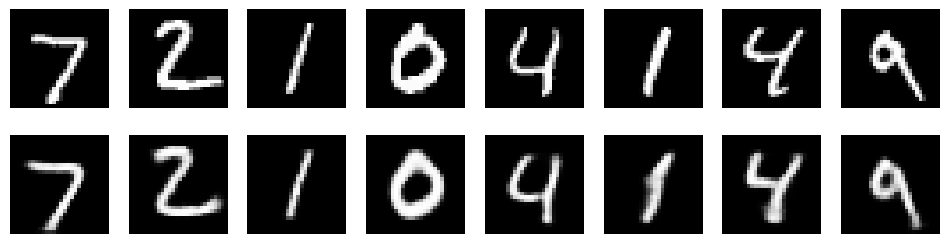

In [ ]:
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x     = x.to(device)[:8]
    recon, _, _ = model(x)
    fig, axes = plt.subplots(2, 8, figsize=(12,3))
    for i in range(8):
        axes[0,i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0,i].axis('off')
        axes[1,i].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[1,i].axis('off')
    plt.show()

with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    samples = model.decoder(model.decoder_input(z))
    fig, axes = plt.subplots(1, 8, figsize=(12,2))
    for i in range(8):
        axes[i].imshow(samples[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

## 8. t-SNE and TensorBoard Visualization

In [ ]:
model.eval()
latent_vectors = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        h = model.encoder(x)
        mu = model.fc_mu(h)
        latent_vectors.append(mu.cpu())
        labels.append(y)
latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(latent_vectors.numpy())

plt.figure(figsize=(8,6))
scatter = plt.scatter(z_tsne[:,0], z_tsne[:,1], c=labels.numpy(), s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE of VAE Latent Space')
plt.show()

tensorboard_logdir = 'runs/vae_tsne'
writer = SummaryWriter(tensorboard_logdir)

sample_imgs, sample_labels = next(iter(test_loader))
sample_imgs = sample_imgs[:100]
sample_labels = sample_labels[:100]
with torch.no_grad():
    h = model.encoder(sample_imgs.to(device))
    sample_mu = model.fc_mu(h).cpu()

writer.add_embedding(
    sample_mu,
    metadata=sample_labels.tolist(),
    label_img=sample_imgs
)
writer.close()
print(f"Run `tensorboard --logdir={tensorboard_logdir}` to visualize embeddings.")

Run `tensorboard --logdir=runs/vae_tsne` to visualize embeddings.
